In [43]:
import sys
import numpy 
import matplotlib
import seaborn #to plot correlation matrix
import scipy
import pandas

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [45]:
#importing dataset 
data = pd.read_csv('creditcard.csv')

In [46]:
#exploring dataset
print(data.columns)
print(data.shape)
#V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
(284807, 31)


In [47]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [48]:
#we will be working on a fraction of dataset considering calculation requiremnets
data= data.sample(frac=0.8,random_state=1)
data.shape

(227846, 31)

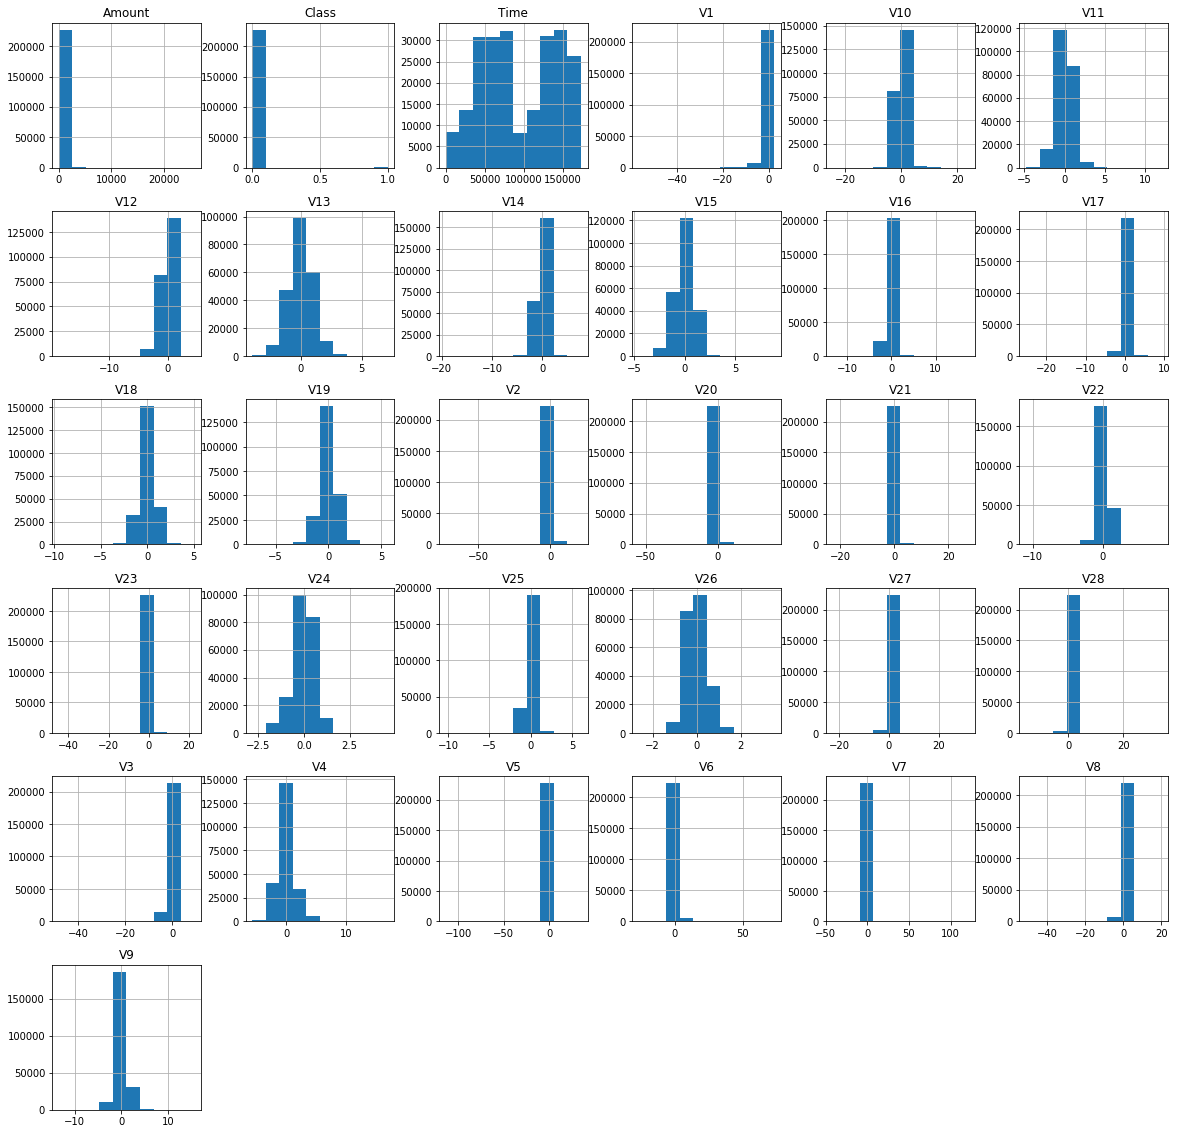

In [49]:
#plotting histograms
data.hist(figsize=(20,20))
plt.show()

In [50]:
# Determine number of fraud cases in dataset
fraud_data = data[data['Class']==1]
valid_data = data[data['Class']==0]

outlier_fraction = len(fraud_data)/float(len(valid_data))
print(outlier_fraction)
print('Fraud Cases :{}'.format(len(fraud_data)))
print('valid Cases :{}'.format(len(valid_data)))

0.001749850515282614
Fraud Cases :398
valid Cases :227448


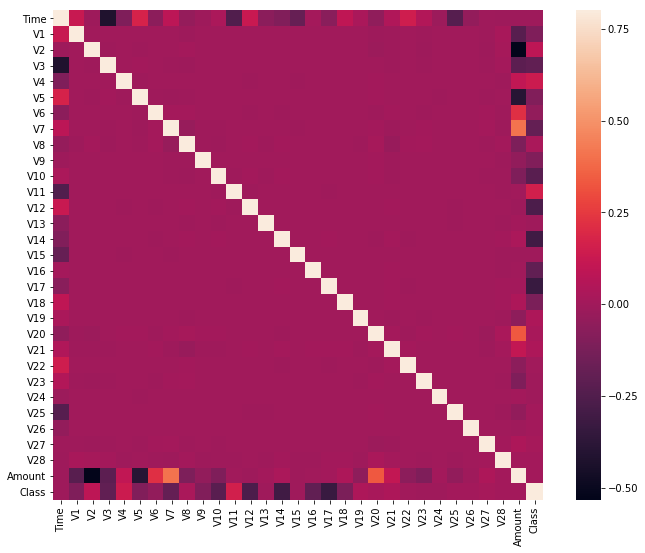

In [51]:
#correlation matrics
corrmat = data.corr()
fig = plt.figure(figsize=(12,9))

sns.heatmap(corrmat, vmax=0.8, square=True)
plt.show()

In [52]:
#Get all the columns from the dataFrame
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

#Store the variable we'll be predicting on
target = 'Class'

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(227846, 30)
(227846,)


## 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms.  We will use the following techniques: 

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a 
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the 
object is with respect to the surrounding neighborhood.


**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to 
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [53]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [54]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(fraud_data)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))
plt.show()

/home/sanju/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Isolation Forest: 505
0.9977835906708917
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    227448
          1       0.37      0.37      0.37       398

avg / total       1.00      1.00      1.00    227846

Local Outlier Factor: 763
0.9966512468948324
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    227448
          1       0.04      0.04      0.04       398

avg / total       1.00      1.00      1.00    227846



<Figure size 648x504 with 0 Axes>